In [25]:
import os, warnings, sys, yaml
from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv
# warnings.simplefilter('always')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dbpath_old = jnconfig['dbpath_old']
dbpath_new = jnconfig['dbpath_new']

In [26]:
from obspy import read
from obspy.io.xseed import Parser
from obspy.signal import PPSD
from obspy.signal.spectral_estimation import get_nlnm


def psd(segment):
    tr = segment.stream()[0]
    tr = tr.slice(tr.stats.starttime, tr.stats.starttime + 60)
    ppsd = PPSD(tr.stats, metadata=segment.inventory(), ppsd_length=60)
    ppsd.add(tr)
    return ppsd
    # return ppsd._binned_psds
#     ppsd._get_response_from_inventory
#     ppsd.psd_frequencies
#     yield ppsd.psd_times, ppsd.psd_values

def bandpass_remresp(segment, config):
    """Applies a pre-process on the given segment waveform by
    filtering the signal and removing the instrumental response.
    DOES modify the segment stream in-place (see below)

    The filter algorithm has the following steps:
    1. Sets the max frequency to 0.9 of the Nyquist frequency (sampling rate /2)
    (slightly less than Nyquist seems to avoid artifacts)
    2. Offset removal (subtract the mean from the signal)
    3. Tapering
    . Pad data with zeros at the END in order to accommodate the filter transient
nf['bandpass_freq_max']
    5. Apply bandpass filter, where the lower frequency is set according to the magnitude
    6. Remove padded elements
    7. Remove the instrumental response

    IMPORTANT NOTES:
    - Being decorated with '@gui.preprocess', this function:
      * returns the *base* stream used by all plots whenever the relative check-box is on
      * must return either a Trace or Stream object

    - In this implementation THIS FUNCTION DOES MODIFY `segment.stream()` IN-PLACE: from within
      `main`, further calls to `segment.stream()` will return the stream returned by this function.
      However, In any case, you can use `segment.stream().copy()` before this call to keep the
      old "raw" stream

    :return: a Trace object.
    """
    stream = segment.stream()
    assert1trace(stream)  # raise and return if stream has more than one trace
    trace = stream[0]

    inventory = segment.inventory()

    # define some parameters:
    evt = segment.event
    conf = config['preprocess']
    freq_max = conf['bandpass_freq_max']
    if segment.channel.instrument_code.lower() in ('n', 'l', 'g'):
        # accelerometer
        freq_min = mag2freq(evt.magnitude)
    else:
        # velocimeter
        freq_min = conf['velocimeter_freq_min']

    # note: bandpass here below copied the trace! important!
    trace = bandpass(trace, freq_min=freq_min, freq_max=freq_max,
                     max_nyquist_ratio=conf['bandpass_max_nyquist_ratio'],
                     corners=conf['bandpass_corners'], copy=False)
    trace.remove_response(inventory=inventory, output=conf['remove_response_output'],
                          water_level=conf['remove_response_water_level'])
    return trace

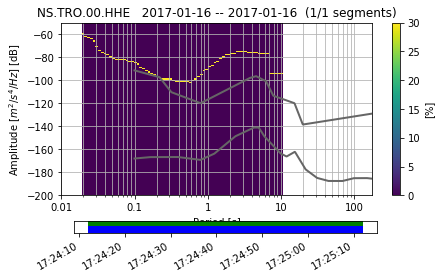

1001


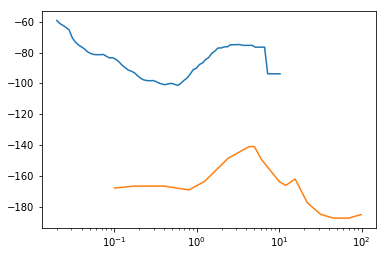

In [27]:
from obspy import Trace, Stream, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

sess = get_session(dbpath_new)
try:
    qry = sess.query(Segment).join(Segment.station).filter(Station.has_inventory &
                                                           Segment.has_data &
                                                           Segment.maxgap_numsamples.between(-0.5,0.5))
    segment = qry.limit(1).first()
    
    _ = psd(segment)
    _.plot()
    # print(_.period_bin_centers.shape, _.psd_values[0].shape)
    plt.semilogx(_.period_bin_centers, _.psd_values[0])
    trace, inv = segment.stream()[0], segment.inventory()
finally:
    sess.close()

p, s = get_nlnm()
print(len(p))
plt.semilogx(p[::-1][:500], s[::-1][:500])
    
def printred(string):
    print("\x1b[31m%s\x1b[0m" % string)

In [ ]:
# all values above 1 period are considered "low freqs". Also consider that values close to 10 have more variability,
# because the source (the physic process) is variable